<table style="border:none; border-collapse:collapse; cellspacing:0; cellpadding:0">
    <tr>
        <td width=30% style="border:none">
            <img src="logo_datascientest.png" width="100%"/>
        </td>
        <td style="border:none">
            <center>
                <h1>DS project: Customer satisfaction</h1>
                <h2>Modelisation - BoW / TF-IDF</h2>
            </center>
        </td>
    </tr>
</table>

<hr>

**Date** : 2023

**Author** : Elie MAZE, Luc Thomas

**Goal** : Train & evaluate models

In [2]:
import _mypath
import os
import shap
import pandas as pd

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import randint
from threadpoolctl import threadpool_limits

import nltk
#nltk.data.path.append("/data/DATALAB_PAU/18_HPC/nltk_data")

from nltk.corpus import stopwords

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 1

In [3]:
from visu.visu import plotCMX, plotErrors
from utils.utils import getErrors

In [4]:
#DATA_FOLDER = "/data/DATALAB_PAU/20_projects/j0215602/DS_NLP/input/labeled"
DATA_FOLDER = r"D:\DevPy\DS_NLP\input\labeled"
#_MAX_WORKERS = 12
_MAX_WORKERS = 8

# __Bag Of Words__

# 2 classes
## Data loading

In [35]:
outfile_2cls_train = os.path.join(DATA_FOLDER, "train_2classes.csv")
df_train = pd.read_csv(outfile_2cls_train, sep=",", encoding="utf-8", engine="python")

outfile_2cls_val = os.path.join(DATA_FOLDER, "val_2classes.csv")
df_val = pd.read_csv(outfile_2cls_val, sep=",", encoding="utf-8", engine="python")

df_train = pd.concat((df_train, df_val))
del df_val

outfile_2cls_test = os.path.join(DATA_FOLDER, "test_2classes.csv")
df_test = pd.read_csv(outfile_2cls_test, sep=",", encoding="utf-8", engine="python")

print("train set:", df_train.shape)
print("test set:", df_test.shape)

train set: (79324, 11)
test set: (19832, 11)


## Data prep
### Encode labels

In [36]:
mapping = {1:0, 2:0, 
           4:2, 5:2}

df_train["Sentiment_code"] = df_train["star"].replace(mapping).astype(int)
df_test["Sentiment_code"] = df_test["star"].replace(mapping).astype(int)

### Features creation

In [37]:
# Create features
vectorizer = CountVectorizer(max_features=2000, stop_words=stopwords.words('french'))
X_train = vectorizer.fit_transform(df_train["cleaned_lemma"].values)
y_train = df_train["Sentiment_code"].values

X_test = vectorizer.transform(df_test["cleaned_lemma"].values)
y_test = df_test["Sentiment_code"].values

# taille du vocabulaire
voc = vectorizer.vocabulary_
print('Vocabulary size: ', len(voc))

# Affichage d'un échantilllon du vocabulaire
print({k: voc[k] for k in list(voc)[:10]})

Vocabulary size:  2000
{'conseil': 452, 'vendre': 1907, 'produit': 1430, 'téléphone': 1873, 'recevoir': 1521, 'complètement': 421, 'référence': 1647, 'commande': 401, 'pc': 1328, 'bien': 246}


## Training

In [39]:
param_dist = {'n_estimators': randint(10, 1000),
              'max_features': ['sqrt', 'log2'],
              'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

rf = RandomForestClassifier()

rscv = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                          scoring='accuracy', n_iter=15, cv=3, random_state=42, n_jobs=_MAX_WORKERS)

with threadpool_limits(limits=_MAX_WORKERS):
    rscv.fit(X_train, y_train)

In [40]:
print('Best hyperparameters:', rscv.best_params_)

Best hyperparameters: {'max_depth': 80, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 131}


In [41]:
rf = RandomForestClassifier(**rscv.best_params_)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=80, min_samples_split=10, n_estimators=131)

## Evaluation

Labels: [0, 2]


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


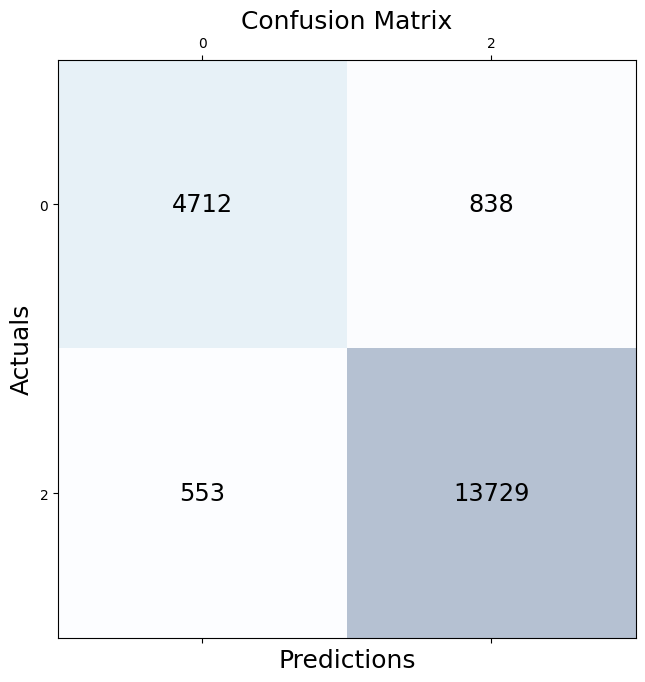

In [44]:
LABELS = [0,2]
print("Labels:", LABELS)

y_pred = rf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plotCMX(LABELS, cm)

In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87      5550
           2       0.94      0.96      0.95     14282

    accuracy                           0.93     19832
   macro avg       0.92      0.91      0.91     19832
weighted avg       0.93      0.93      0.93     19832



In [46]:
errors = getErrors(df_test, y_test, y_pred, col_x="star", col_input="cleaned_lemma")
errors

,errors,total,error_rate
star,,,
1,531,4819,0.110189
2,307,731,0.419973
4,247,3725,0.066309
5,306,10557,0.028986


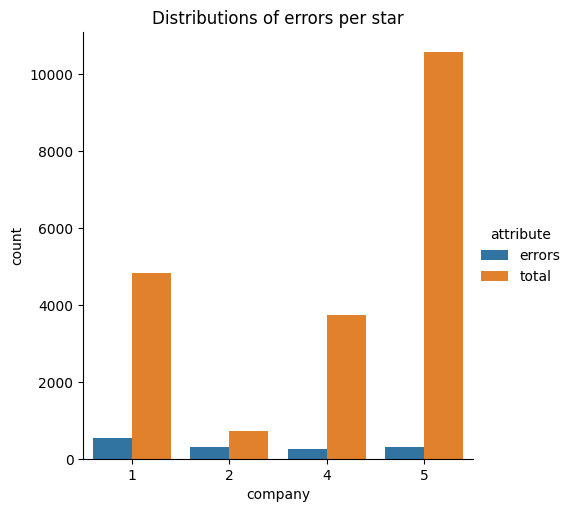

In [47]:
plotErrors(errors, col_x="star")

# 5 classes
## Data loading

In [48]:
outfile_5cls_train = os.path.join(DATA_FOLDER, "train_5classes.csv")
df_train = pd.read_csv(outfile_5cls_train, sep=",", encoding="utf-8", engine="python")

outfile_5cls_val = os.path.join(DATA_FOLDER, "val_5classes.csv")
df_val = pd.read_csv(outfile_5cls_val, sep=",", encoding="utf-8", engine="python")

df_train = pd.concat((df_train, df_val))
del df_val

outfile_5cls_test = os.path.join(DATA_FOLDER, "test_5classes.csv")
df_test = pd.read_csv(outfile_5cls_test, sep=",", encoding="utf-8", engine="python")

print("train set:", df_train.shape)
print("test set:", df_test.shape)

train set: (84407, 11)
test set: (21104, 11)


## Data prep
### Features creation

In [51]:
# Create features
vectorizer = CountVectorizer(max_features=2000, stop_words=stopwords.words('french'))
X_train = vectorizer.fit_transform(df_train["cleaned_lemma"].values)
y_train = df_train["star"].values

X_test = vectorizer.transform(df_test["cleaned_lemma"].values)
y_test = df_test["star"].values

# taille du vocabulaire
voc = vectorizer.vocabulary_
print('Vocabulary size: ', len(voc))

# Affichage d'un échantilllon du vocabulaire
print({k: voc[k] for k in list(voc)[:10]})

Vocabulary size:  2000
{'suite': 1760, 'réponse': 1658, 'cdiscount': 328, 'confirmer': 446, 'compte': 428, 'devenir': 557, 'avis': 215, 'recevoir': 1521, 'aucun': 196, 'message': 1153}


## Training

In [52]:
param_dist = {'n_estimators': randint(10, 1000),
              'max_features': ['sqrt', 'log2'],
              'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

rf = RandomForestClassifier()

rscv = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                          scoring='accuracy', n_iter=15, cv=3, random_state=42, n_jobs=_MAX_WORKERS)

with threadpool_limits(limits=_MAX_WORKERS):
    rscv.fit(X_train, y_train)

In [53]:
print('Best hyperparameters:', rscv.best_params_)

Best hyperparameters: {'max_depth': 80, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 131}


In [54]:
rf = RandomForestClassifier(**rscv.best_params_)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=80, min_samples_split=10, n_estimators=131)

## Evaluation

Labels: [1, 2, 3, 4, 5]


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


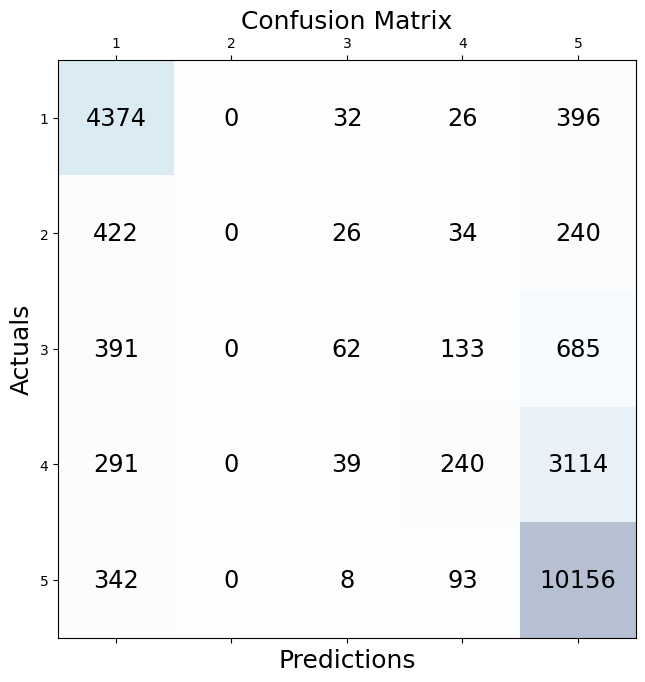

In [55]:
LABELS = [1, 2, 3, 4, 5]
print("Labels:", LABELS)

y_pred = rf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plotCMX(LABELS, cm)

In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.75      0.91      0.82      4828
           2       0.00      0.00      0.00       722
           3       0.37      0.05      0.09      1271
           4       0.46      0.07      0.11      3684
           5       0.70      0.96      0.81     10599

    accuracy                           0.70     21104
   macro avg       0.46      0.40      0.37     21104
weighted avg       0.62      0.70      0.62     21104



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [57]:
errors = getErrors(df_test, y_test, y_pred, col_x="star", col_input="cleaned_lemma")
errors

,errors,total,error_rate
star,,,
1,454,4828,0.094035
2,722,722,1.000000
3,1209,1271,0.951220
4,3444,3684,0.934853
5,443,10599,0.041796


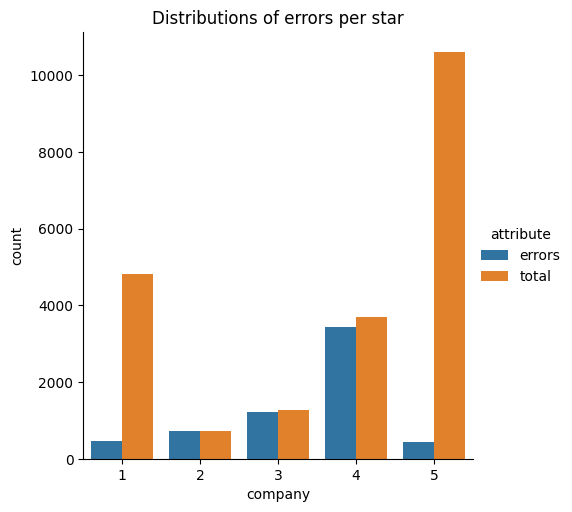

In [58]:
plotErrors(errors, col_x="star")    

# __TF-IDF__

# 2 classes
## Data loading

In [5]:
outfile_2cls_train = os.path.join(DATA_FOLDER, "train_2classes.csv")
df_train = pd.read_csv(outfile_2cls_train, sep=",", encoding="utf-8", engine="python")

outfile_2cls_val = os.path.join(DATA_FOLDER, "val_2classes.csv")
df_val = pd.read_csv(outfile_2cls_val, sep=",", encoding="utf-8", engine="python")

df_train = pd.concat((df_train, df_val))
del df_val

outfile_2cls_test = os.path.join(DATA_FOLDER, "test_2classes.csv")
df_test = pd.read_csv(outfile_2cls_test, sep=",", encoding="utf-8", engine="python")

print("train set:", df_train.shape)
print("test set:", df_test.shape)

train set: (79324, 11)
test set: (19832, 11)


## Data prep
### Label encoding

In [6]:
mapping = {1:0, 2:0, 
           4:1, 5:1}

df_train["Sentiment_code"] = df_train["star"].replace(mapping).astype(int)
df_test["Sentiment_code"] = df_test["star"].replace(mapping).astype(int)

y_train = df_train["Sentiment_code"].values
y_test = df_test["Sentiment_code"].values

### Features

In [7]:
# Application de TF-IDF aux avis
vectorizer = TfidfVectorizer(max_features=5000, stop_words=stopwords.words('french'), ngram_range=(1,1))
X_train_tfidf = vectorizer.fit_transform(df_train["cleaned_lemma"].values)
X_test_tfidf = vectorizer.transform(df_test["cleaned_lemma"].values)

## Training

In [8]:
param_dist = {'n_estimators': randint(10, 1000),
              'max_features': ['sqrt', 'log2'],
              'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

rf = RandomForestClassifier()

rscv = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                          scoring='accuracy', n_iter=15, cv=3, random_state=42, n_jobs=_MAX_WORKERS)

with threadpool_limits(limits=_MAX_WORKERS):
    rscv.fit(X_train_tfidf, y_train)
    
print('Best hyperparameters:', rscv.best_params_)

Best hyperparameters: {'max_depth': 80, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 131}


In [9]:
rf = RandomForestClassifier(**rscv.best_params_)
rf.fit(X_train_tfidf, y_train)

RandomForestClassifier(max_depth=80, max_features='sqrt', min_samples_split=10,
                       n_estimators=131)

## Evaluation

Labels: [0, 1]


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


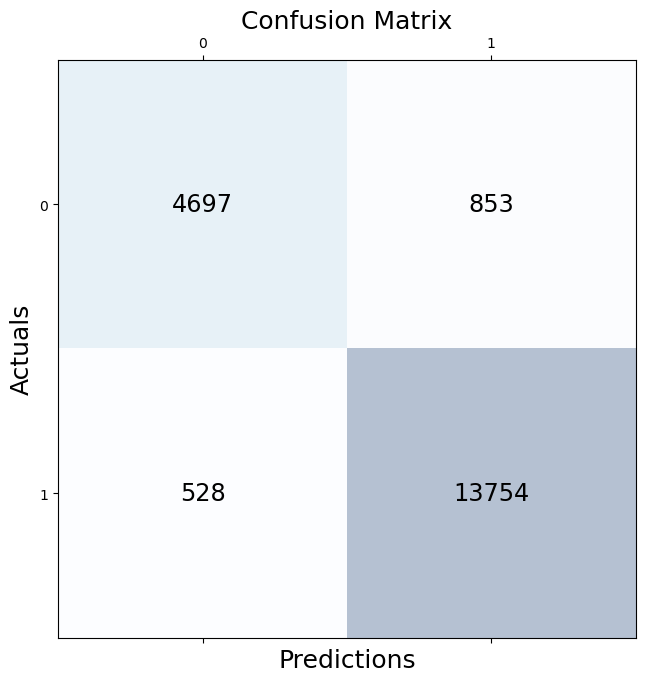

In [10]:
LABELS = [0, 1]
print("Labels:", LABELS)

y_pred = rf.predict(X_test_tfidf)

cm = confusion_matrix(y_test, y_pred)
plotCMX(LABELS, cm)

In [11]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.85      0.87      5550
           1       0.94      0.96      0.95     14282

    accuracy                           0.93     19832
   macro avg       0.92      0.90      0.91     19832
weighted avg       0.93      0.93      0.93     19832



In [12]:
errors = getErrors(df_test, y_test, y_pred, col_x="star")
errors

,errors,total,error_rate
1,551,4819,0.114339
2,302,731,0.413133
4,245,3725,0.065772
5,283,10557,0.026807


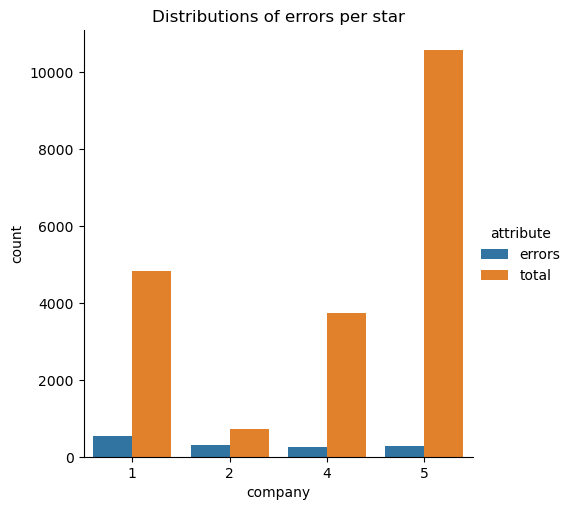

In [13]:
plotErrors(errors, col_x="star")  

Les résultats de l'approche TF-IDF sont similaires au BoW en prenant un range de n-grams de 1.  
Les résultats sont moins bons avec un range [2:4].

## Explicability

In [14]:
explainer = shap.TreeExplainer(rf, data=X_test_tfidf.toarray())

shap_values = explainer.shap_values(X_test_tfidf.todense(), approximate=True)

print('Expected Value:', explainer.expected_value)

pd.DataFrame(np.vstack(shap_values)).head()

Expected Value: [0.23316156 0.76683844]


,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.003292,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.003502,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.002478,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.016451,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037466,0.0,0.0


Importance globale de chaque variable:
- _class 0: POSITIVE_  
- _class 1: NEGATIVE_

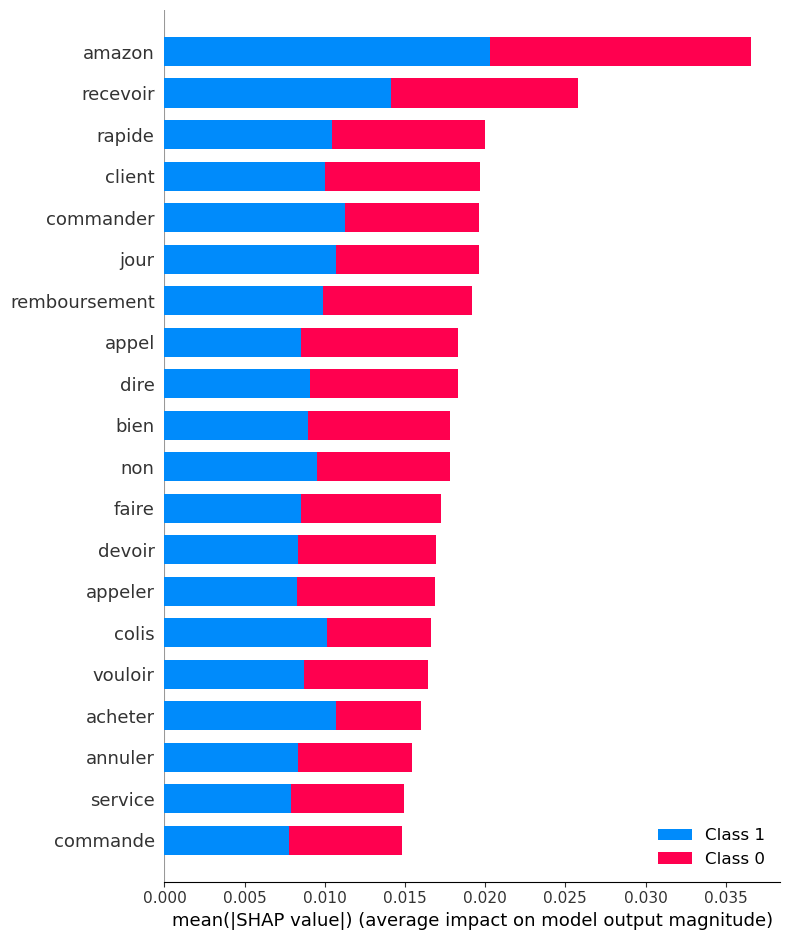

In [15]:
shap.summary_plot(shap_values, X_test_tfidf, feature_names=vectorizer.get_feature_names_out(), plot_type="bar")

array([[<AxesSubplot: title={'center': '0'}>]], dtype=object)

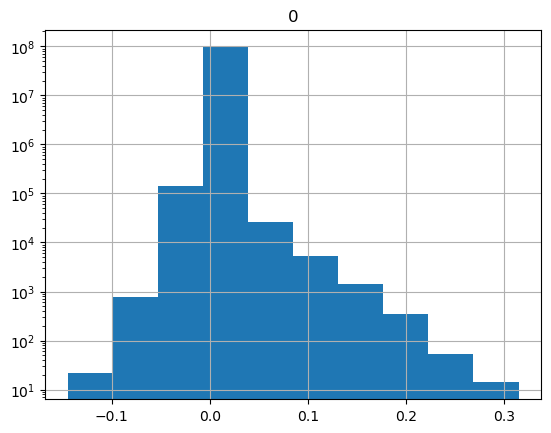

In [64]:
pd.DataFrame(shap_values[0].flatten()).hist(log=True)

array([[<AxesSubplot: title={'center': '0'}>]], dtype=object)

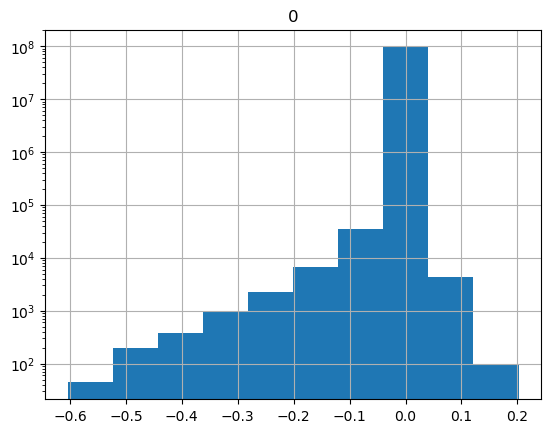

In [65]:
pd.DataFrame(shap_values[1].flatten()).hist(log=True)

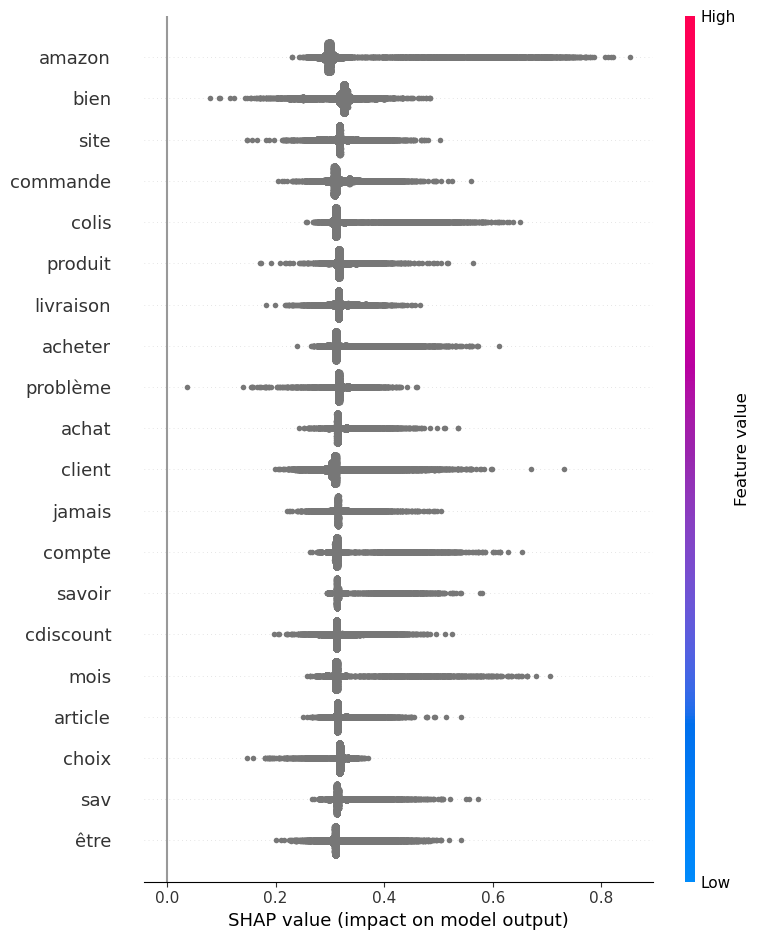

In [60]:
shap_values_normalized = (shap_values[0] - shap_values[0].min()) / (shap_values[0].max() - shap_values[0].min())

from matplotlib.colors import LinearSegmentedColormap
colors = ["#1a9641", "#a6d96a", "#fdae61", "#d7191c"]  # Choisissez vos couleurs personnalisées
cmap_custom = LinearSegmentedColormap.from_list("CustomColormap", colors)


shap.summary_plot(shap_values_normalized, X_test_tfidf, feature_names=vectorizer.get_feature_names_out(), 
                  plot_type="dot", color=cmap_custom)
plt.show()

Interprétabilité locale à une observation:

In [18]:
shap.initjs()
idx = 7
print(df_test["Commentaire"].values[idx])
print('\n- Prediction :', y_pred[idx])
print('- True value :', y_test[idx])
shap.force_plot(explainer.expected_value[0], shap_values[0][idx], X_test_tfidf[idx].toarray()[0], feature_names=vectorizer.get_feature_names_out())

Service client catastrophique le téléphone portable de ma fille est tombé en panne au bout de 6 mois d'utilisation malgré 8 mails de relance afin de connaître la marche à suivre aucun retour de leur part c'est inadmissible pour moi Cdiscount c'est fini. Le service client d'Amazon et beaucoup plus efficace et rapide dans le traitement des réclamations

- Prediction : 0
- True value : 0


In [17]:
shap.force_plot(explainer.expected_value[1], shap_values[1][idx], X_test_tfidf[idx].toarray()[0], feature_names=vectorizer.get_feature_names_out())

# 5 classes
## Data loading

In [66]:
outfile_5cls_train = os.path.join(DATA_FOLDER, "train_5classes.csv")
df_train = pd.read_csv(outfile_5cls_train, sep=",", encoding="utf-8", engine="python")

outfile_5cls_val = os.path.join(DATA_FOLDER, "val_5classes.csv")
df_val = pd.read_csv(outfile_5cls_val, sep=",", encoding="utf-8", engine="python")

df_train = pd.concat((df_train, df_val))
del df_val

outfile_5cls_test = os.path.join(DATA_FOLDER, "test_5classes.csv")
df_test = pd.read_csv(outfile_5cls_test, sep=",", encoding="utf-8", engine="python")

print("train set:", df_train.shape)
print("test set:", df_test.shape)

train set: (84407, 11)
test set: (21104, 11)


## Data prep
### Features creation

In [70]:
# Application de TF-IDF aux avis
vectorizer = TfidfVectorizer(max_features=5000, stop_words=stopwords.words('french'), ngram_range=(1,1))
X_train_tfidf = vectorizer.fit_transform(df_train["cleaned_lemma"].values)
X_test_tfidf = vectorizer.transform(df_test["cleaned_lemma"].values)

In [68]:
y_train = df_train["star"].values
y_test = df_test["star"].values

## Training

In [71]:
param_dist = {'n_estimators': randint(10, 1000),
              'max_features': ['sqrt', 'log2'],
              'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

rf = RandomForestClassifier()

rscv = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                          scoring='accuracy', n_iter=15, cv=3, random_state=42, n_jobs=_MAX_WORKERS)

with threadpool_limits(limits=_MAX_WORKERS):
    rscv.fit(X_train_tfidf, y_train)
    
print('Best hyperparameters:', rscv.best_params_)

Best hyperparameters: {'max_depth': 80, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 131}


In [72]:
rf = RandomForestClassifier(**rscv.best_params_)
rf.fit(X_train_tfidf, y_train)

RandomForestClassifier(max_depth=80, max_features='sqrt', min_samples_split=10,
                       n_estimators=131)

## Evaluation

Labels: [1, 2, 3, 4, 5]


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


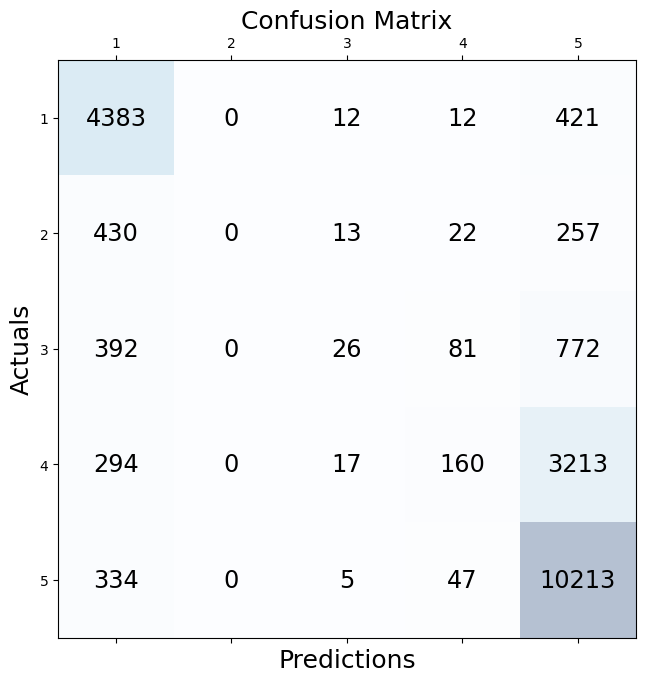

In [73]:
LABELS = [1, 2, 3, 4, 5]
print("Labels:", LABELS)

y_pred = rf.predict(X_test_tfidf)

cm = confusion_matrix(y_test, y_pred)
plotCMX(LABELS, cm)

In [74]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.75      0.91      0.82      4828
           2       0.00      0.00      0.00       722
           3       0.36      0.02      0.04      1271
           4       0.50      0.04      0.08      3684
           5       0.69      0.96      0.80     10599

    accuracy                           0.70     21104
   macro avg       0.46      0.39      0.35     21104
weighted avg       0.62      0.70      0.61     21104



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [75]:
errors = getErrors(df_test, y_test, y_pred, col_x="star")
errors

,errors,total,error_rate
1,445,4828,0.092171
2,722,722,1.000000
3,1245,1271,0.979544
4,3524,3684,0.956569
5,386,10599,0.036419


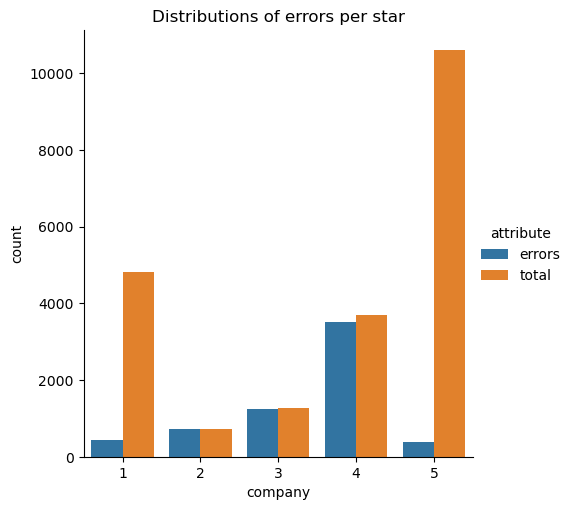

In [76]:
plotErrors(errors, col_x="star")  

# __Explicability__

Afficher l'importance globale de chaque variable.

In [77]:
explainer = shap.TreeExplainer(rf, data=X_test_tfidf.toarray())

shap_values = explainer.shap_values(X_test_tfidf.todense(), approximate=True)

print('Expected Value:', explainer.expected_value)

pd.DataFrame(np.vstack(shap_values)).head()

Expected Value: [0.19357607 0.03139402 0.06027501 0.18525411 0.52950079]


,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.013629,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.007752,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,7.535721e-03,0.0,0.0,0.0,0.0,-0.000809,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.421011e-20,0.0,0.0,0.0,0.0,-0.001157,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.055410,0.0,0.0


Importance globale de chaque variable.

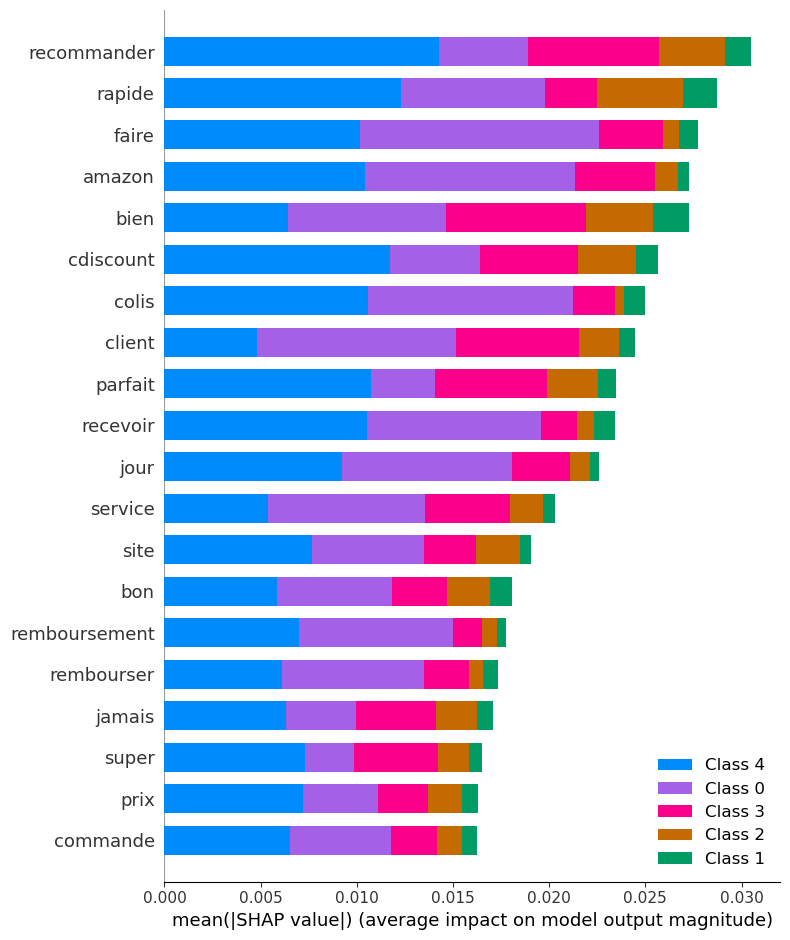

In [78]:
shap.summary_plot(shap_values, X_test_tfidf, feature_names=vectorizer.get_feature_names_out(), plot_type="bar")

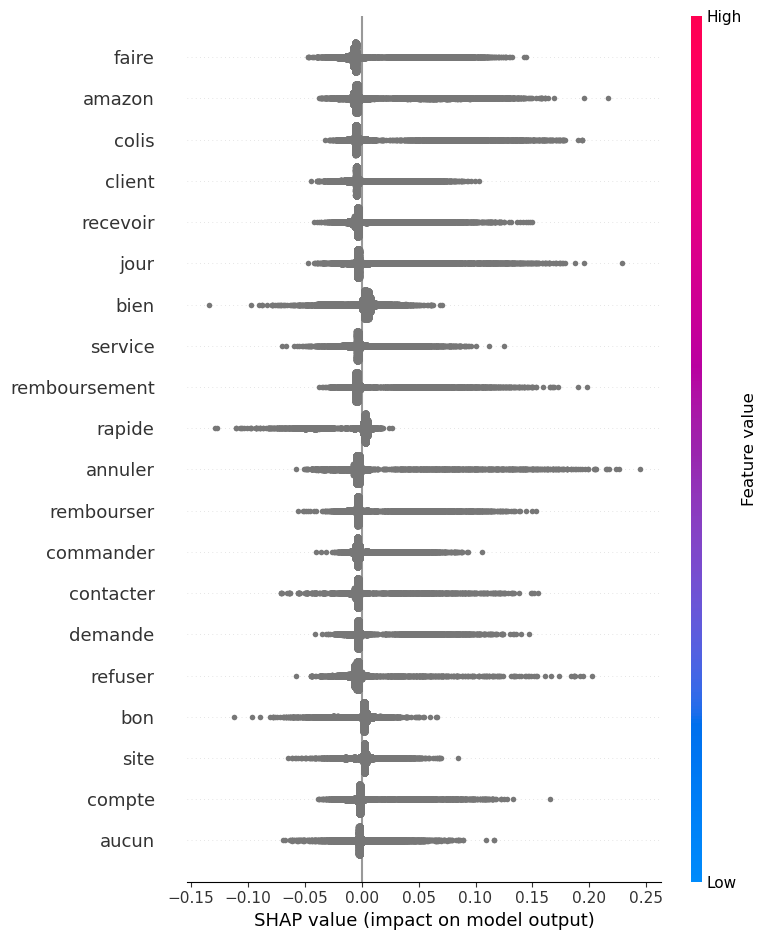

In [79]:
shap.summary_plot(shap_values[0], X_test_tfidf, feature_names=vectorizer.get_feature_names_out())

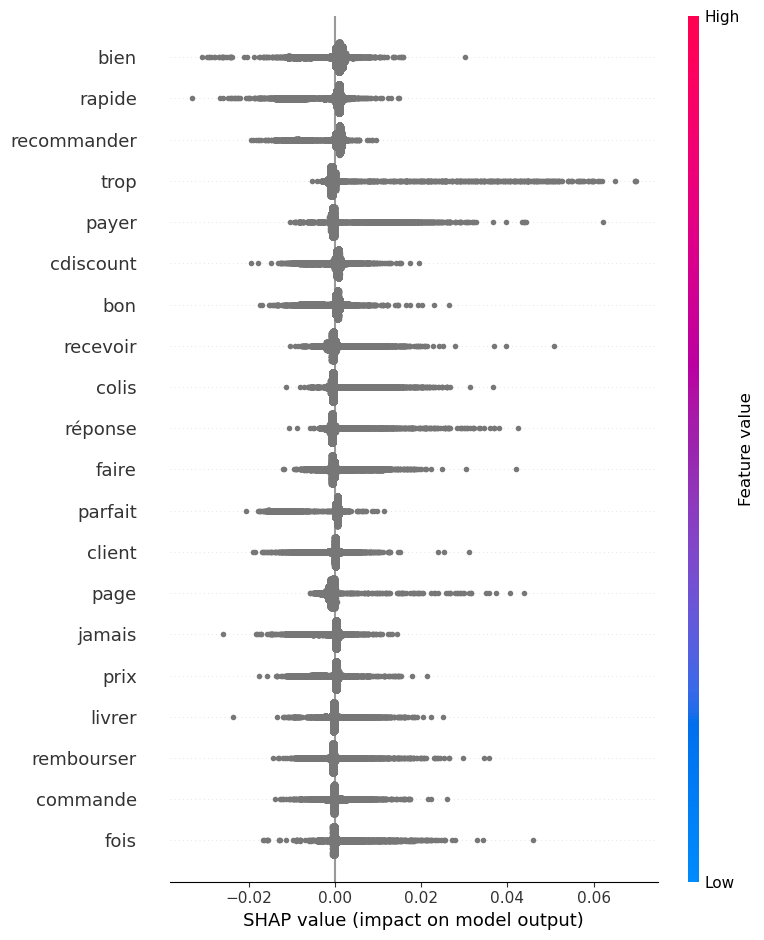

In [80]:
shap.summary_plot(shap_values[1], X_test_tfidf, feature_names=vectorizer.get_feature_names_out())

Interprétabilité locale à une observation:

In [81]:
shap.initjs()
idx = 7
print(df_test["Commentaire"].values[idx])
print('\n- Prediction :', y_pred[idx])
print('- True value :', y_test[idx])
shap.force_plot(explainer.expected_value[0], shap_values[0][idx], X_test_tfidf[idx].toarray()[0], feature_names=vectorizer.get_feature_names_out())

Bonjour j’ai eu un conseiller hier très mal poli Cela fait 6 ans que je suis chez vous et c la première fois que l’on me parle comme ça Bien à vous

- Prediction : 5
- True value : 1


In [82]:
shap.force_plot(explainer.expected_value[1], shap_values[1][idx], X_test_tfidf[idx].toarray()[0], feature_names=vectorizer.get_feature_names_out())

In [83]:
shap.force_plot(explainer.expected_value[2], shap_values[2][idx], X_test_tfidf[idx].toarray()[0], feature_names=vectorizer.get_feature_names_out())

In [84]:
shap.force_plot(explainer.expected_value[3], shap_values[3][idx], X_test_tfidf[idx].toarray()[0], feature_names=vectorizer.get_feature_names_out())

In [85]:
shap.force_plot(explainer.expected_value[4], shap_values[4][idx], X_test_tfidf[idx].toarray()[0], feature_names=vectorizer.get_feature_names_out())